In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cubedsphere as cs

import matplotlib.colors as colors # for log scale plot

In [2]:
# get gamap's WhGrYlRd color scheme from file
from matplotlib.colors import ListedColormap
WhGrYlRd_scheme = np.genfromtxt('colormap/WhGrYlRd.txt',delimiter=' ')
WhGrYlRd = ListedColormap(WhGrYlRd_scheme/255.0)

In [3]:
# NCL colormap for Python: https://github.com/hhuangwx/cmaps
# Color tables: https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml
from cmaps import GMT_ocean 

## Read data

In [4]:
datadir = "~/FV3/output/processed/timeseries/"

dr_mm = xr.open_dataarray(datadir+'plume01_ts_meri_C384L160.nc',decode_times=False)

In [5]:
ds_vm = xr.open_dataset(datadir+'plume01_ts_vmean_C384L160.nc',decode_times=False)
dr_vm = ds_vm['plume01']

### initial condition

In [6]:
ds_init = cs.open_FV3data('../../rundirs/C384/INPUT/',"fv_tracer.res",restart=True).isel(time=0)

dr_init = ds_init['plume01']
dr_init_vm = ds_init['plume01'].mean(dim='pfull')
dr_init_mm = cs.meridional_mean(dr_init, dlon=10*48/384)

In [7]:
# to show the initial plume as a whole
def shift_ds(ds, lon_shift):
    ds_shifted = ds.copy()
    ds_shifted['lon'] += lon_shift
    ds_shifted['lon_b'] += lon_shift
    return ds_shifted

# Plots for paper

## vertical mean

In [8]:
xticks = np.array([-180, -120, -60, 0, 60, 120])
xticklabels = ['180$\degree$', 
                 '120$\degree$W', 
                 '60$\degree$W', 
                 '0$\degree$', 
                 '60$\degree$E', 
                 '120$\degree$E']

yticks = np.array([30, 60, 90])
yticklabels = ['30$\degree$N', 
                 '60$\degree$N', 
                 '90$\degree$N'
              ]

plotting time= 0
plotting time= 4
plotting time= 8


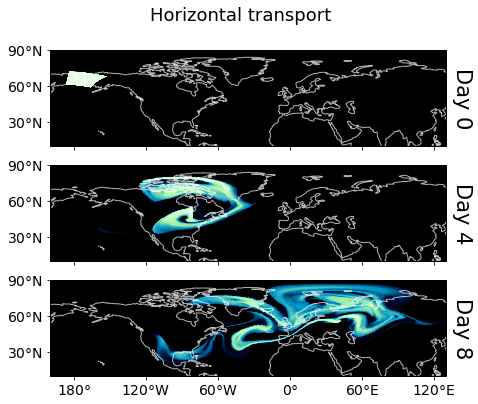

In [9]:
eps = 1e-20 # correct negative values

lon_shift = 30
proj = ccrs.PlateCarree(central_longitude=-lon_shift)

#vmin,vmax = [0,0.05] # for linear scale
vmin,vmax = [1e-5,1e-1] # for log scale
time_list = [0,4,8]

fig, axes = plt.subplots(len(time_list),1,figsize=[8,6],
                         subplot_kw=dict(projection=proj))

for t,time in enumerate(time_list):
    print("plotting time=",time)
    ax = axes[t]
    
    if time == 0:
        dr_temp = dr_init_vm
    else:
        dr_temp = dr_vm.isel(time=time-1)
        
    # correct negative value for log plots
    # dr.values points to the same physical address
    data_temp = dr_temp.values
    data_temp[data_temp < eps] = eps
        
    im = cs.plotCS(dr_temp,shift_ds(ds_init,lon_shift),ax,vmin=vmin, vmax=vmax,
                   norm=colors.LogNorm(vmin=vmin, vmax=vmax), # log scale
                   cmap=GMT_ocean)
    
    ax.set_ylim([10,90]);ax.set_xlim([-170,160])
    ax.coastlines(alpha=0.7, color='white')
    # ax.set_title("day={0}".format(time),fontsize=12,y=0.97)
    
    #https://matplotlib.org/users/text_props.html
    ax.text(1.04, 0.5, "Day {}".format(time), fontsize=21,
            horizontalalignment='center',
            verticalalignment='center',
            rotation=-90.0,
            transform=ax.transAxes)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels( yticklabels, fontsize=14)

    ax.set_xticks(xticks+lon_shift)
    if time == 8:
        ax.set_xticklabels( xticklabels, fontsize=14)
    else:
        ax.set_xticklabels([])

#cb = fig.colorbar(im, ax=axes.tolist(), pad=0.0, orientation='horizontal',
#                  shrink=0.3,ticks=[vmin,1e-3,vmax])

#cb.set_label("mixing ratio (v/v)",fontsize=12)
#cb.ax.tick_params(labelsize=12)

fig.suptitle('Horizontal transport', fontsize=18)

fig.savefig('plume01_C384L160_ts_vertical_average.png',dpi=400)

## meridional mean

In [11]:
# for the vertical gridinfo
ds_20L = xr.open_dataset("/u/jzhuang1/FV3/output/C48/C48L20/atmos_static.tile1.nc",decode_times=False)
pfull_20L = ds_20L['pfull'].copy().values

plotting time= 0
plotting time= 4
plotting time= 8


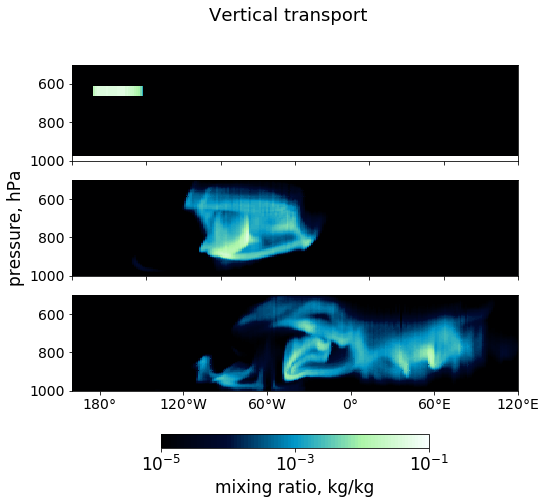

In [12]:
lon_shift = 30; ind_lon_shift = lon_shift//(10*48/384)

#vmin,vmax = [0,0.04] # for linear scale
vmin,vmax = [1e-5,1e-1] # for log scale

time_list = [0,4,8]

fig, axes = plt.subplots(len(time_list),1,figsize=[8, 8])

for t,time in enumerate(time_list):
    print("plotting time=",time)
    ax = axes[t]
    
    if time == 0:
        dr = dr_init_mm
        pfull = pfull_20L
        
        lon_bins = dr['lon_bins'].copy().values - 180.0 - lon_shift
        dr = dr.roll( lon_bins= int(-dr['lon_bins'].size/2+ind_lon_shift) )
        
        data = dr.values
        
    else:
        dr = dr_mm
        
        pfull = dr['pfull'].copy().values
        #lon_bins = dr['lon_bins'].copy().values - 180.0 - lon_shift
        dr = dr.roll(lon_bins=int(-dr['lon_bins'].size/2+ind_lon_shift))
        
        data = dr.isel(time=time-1).values
        
    # correct negative value for log plots
    data[data < eps] = eps
    
    im = ax.pcolormesh(lon_bins,pfull,data,cmap=GMT_ocean,vmax=vmax,vmin=vmin,
                       norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    
    # ax.set_title("day={0}".format(time),fontsize=12,y=0.97)     
    ax.set_ylim([1000,500]);ax.set_xlim([-200,100])
    if time == time_list[1]: 
        ax.set_ylabel('pressure, hPa',fontsize=17)
    ax.set_yticks([1000,800,600])
    ax.set_yticklabels([1000,800,600], fontsize=14)
    
    if time == time_list[-1]:
        ax.set_xticks(xticks)
        ax.set_xticklabels( xticklabels, fontsize=14)
    else:
        ax.xaxis.set_ticklabels([])
    
cb = fig.colorbar(im, ax=axes.tolist(), pad=0.1, orientation='horizontal',
             shrink=0.6,ticks=[vmin,1e-3,vmax])
cb.set_label("mixing ratio, kg/kg",fontsize=17)
cb.ax.tick_params(labelsize=17)

fig.suptitle('Vertical transport', fontsize=18)
#fig.savefig('plume01_C384L160_ts_meri_average.png', dpi=400)
fig.savefig('wide_plume01_C384L160_ts_meri_average.png', dpi=400)

# Plots for animation

In [13]:
lon_shift = 30
proj = ccrs.PlateCarree(central_longitude=-lon_shift)

vmin,vmax = [0,0.05]
time_list = range(9)


for t,time in enumerate(time_list):
    print("plotting time=",time)
    
    fig, ax = plt.subplots(1,1,figsize=[20,8],
                         subplot_kw=dict(projection=proj))
        
    if time == 0:
        dr_temp = dr_init_vm
    else:
        dr_temp = dr_vm.isel(time=time-1)
        
    im = cs.plotCS(dr_temp,shift_ds(ds_init,lon_shift),ax,
                   vmin=vmin, vmax=vmax, cmap=WhGrYlRd)
    
    ax.set_ylim([-20,90]);ax.set_xlim([-170,160])
    ax.coastlines(alpha=0.3)
    ax.set_title("day={0}".format(time),fontsize=25)     

    fig.colorbar(im, ax=ax, pad=0.02, orientation='vertical',
                 shrink=0.7,ticks=np.linspace(vmin,vmax,3)).\
                 set_label("mixing ratio (v/v)",fontsize=15)
    fig.tight_layout()
    fig.savefig('outputfig/animation/vmean_day{0}'.format(time),dpi=200)
    plt.close() # don't show in this notebook

plotting time= 0
plotting time= 1
plotting time= 2
plotting time= 3
plotting time= 4
plotting time= 5
plotting time= 6
plotting time= 7
plotting time= 8


In [34]:
lon_shift = 30; ind_lon_shift = lon_shift//(10*48/384)
vmin,vmax = [0,0.04]
time_list = range(9)

for t,time in enumerate(time_list):
    print("plotting time=",time)
    fig, ax = plt.subplots(1,1,figsize=[20,8])
    
    if time == 0:
        dr = dr_init_mm
        
        pfull = pfull_20L
        lon_bins = dr['lon_bins'].copy().values - 180.0 - lon_shift
        dr = dr.roll( lon_bins= int(-dr['lon_bins'].size/2+ind_lon_shift) )
        data = dr.values
    else:
        dr = dr_mm
        
        pfull = dr['pfull'].copy().values
        #lon_bins = dr['lon_bins'].copy().values - 180.0 - lon_shift
        dr = dr.roll(lon_bins=int(-dr['lon_bins'].size/2+ind_lon_shift))
        data = dr.isel(time=time-1).values
    
    im = ax.pcolormesh(lon_bins,pfull,data,cmap=WhGrYlRd,vmax=vmax,vmin=vmin)
    
    ax.set_title("day={0}".format(time),fontsize=25)     
    ax.set_ylim([980,500]);ax.set_xlim([-200,100])
    ax.set_ylabel('pressure(hPa)',fontsize=20)
    ax.set_xlabel('longitude',fontsize=20)

    fig.colorbar(im, ax=ax, pad=0.02, orientation='vertical',
                 shrink=0.7,ticks=np.linspace(vmin,vmax,3)).\
                 set_label("mixing ratio (v/v)",fontsize=20)
    fig.tight_layout()
    fig.savefig('outputfig/animation/mmean_day{0}'.format(time),dpi=200)
    plt.close() # don't show in this notebook

plotting time= 0
plotting time= 1
plotting time= 2
plotting time= 3
plotting time= 4
plotting time= 5
plotting time= 6
plotting time= 7
plotting time= 8
